Optimization change number of processes
=======================================

This example shows how to set the number of processes used for optimization. The exact same scenario from [Tutorial 5](../../tutorials/5_first_optimization.ipynb) is used:

The objective is to **minimize the energy required by a LIFE electrode to trigger a single myelinated fiber using a rectangular pulse stimulus**.

.. note::
    For optimization over parallelizable context (nerve or fascicle), the parallelization is done only for the context simulation

.. seealso::
    [Parallel computation](../../usersguide/parallel.rst) and [Optimization](../../usersguide/optimization.rst)  users' guides.

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 11390
NRV INFO: Number of elements : 80986
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.018976449966431 s


PSO optimizer - 1 proc: 100%|██████████|50/50, best_cost=0.0295


best input vector: [3.989542355705061, 0.1852817779181298] 
best cost: 0.029493916445033925


PSO optimizer - 2 procs: 100%|██████████|50/50, best_cost=0.0295


best input vector: [3.989542355705061, 0.1852817779181298] 
best cost: 0.029493916445033925


PSO optimizer - 3 procs: 100%|██████████|50/50, best_cost=0.0295


best input vector: [3.989542355705061, 0.1852817779181298] 
best cost: 0.029493916445033925


PSO optimizer - 4 procs: 100%|██████████|50/50, best_cost=0.0295


best input vector: [3.989542355705061, 0.1852817779181298] 
best cost: 0.029493916445033925


PSO optimizer - 3 procs: 100%|██████████|50/50, best_cost=0.0295


best input vector: [3.989542355705061, 0.1852817779181298] 
best cost: 0.029493916445033925


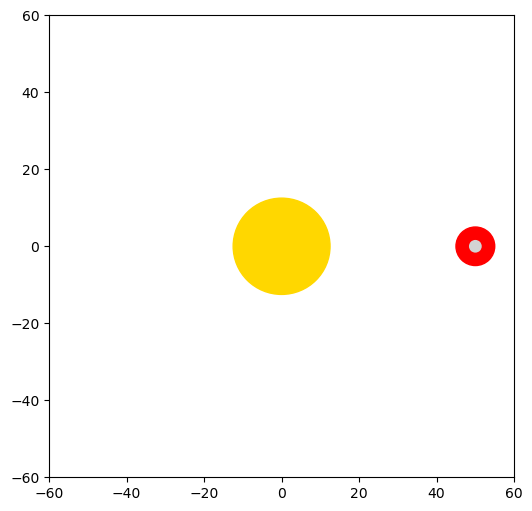

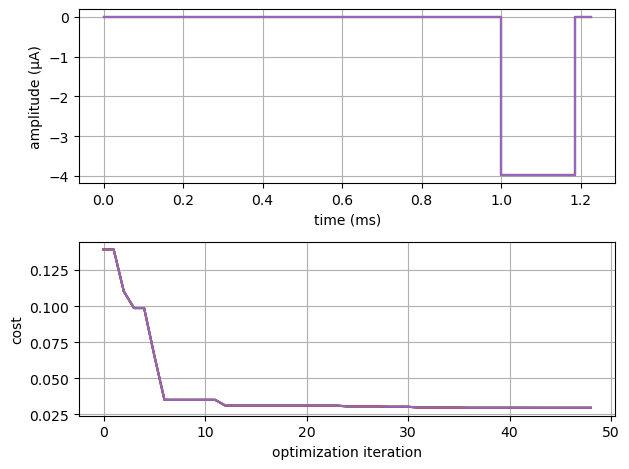

In [1]:
import sys 
sys.path.append("../../../")     #data path
import nrv

import matplotlib.pyplot as plt
import numpy as np
import os

N_test = "227"
figdir = f"./unitary_tests/figures/{N_test}_"

res_dir = f"./Example_/{N_test}"

# -------------------------- #
#  Cost function definition  #
# -------------------------- #
my_cost0 = nrv.cost_function()


# Setting Static Context
axon_file = res_dir + "myelinated_axon.json"

ax_l = 10000 # um
ax_d=10
ax_y=50
ax_z=0
axon_1 = nrv.myelinated(L=ax_l, d=ax_d, y=ax_y, z=ax_z)


LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_nerve(Length=ax_l)
life_d = 25 # um
life_length = 1000 # um
life_x_0_offset = life_length/2
life_y_c_0 = 0
life_z_c_0 = 0
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

dummy_stim = nrv.stimulus()
dummy_stim.pulse(0, 0.1, 1)
LIFE_stim0.add_electrode(elec_0, dummy_stim)

axon_1.attach_extracellular_stimulation(LIFE_stim0)
axon_1.get_electrodes_footprints_on_axon()
axon_dict = axon_1.save(save=False, fname=axon_file, extracel_context=True)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
axon_1.plot(ax)
ax.set_xlim((-1.2*ax_y, 1.2*ax_y))
ax.set_ylim((-1.2*ax_y, 1.2*ax_y))

del axon_1

static_context = axon_dict
t_sim = 5
dt = 0.005
kwarg_sim = {
    "dt":dt,
    "t_sim":t_sim,
}

my_cost0.set_static_context(static_context, **kwarg_sim)

# Setting Context Modifier
t_start = 1
I_max_abs = 100
cm_0 = nrv.biphasic_stimulus_CM(start=t_start, s_cathod="0", t_cathod="1", s_anod=0)
my_cost0.set_context_modifier(cm_0)

# Setting Cost Evaluation
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()
cost_evaluation = costR + 0.01 * costC
my_cost0.set_cost_evaluation(cost_evaluation)


# -------------------------- #
#  PSO Optimizer definition  #
# -------------------------- #
pso_kwargs = {
    "maxiter" : 50,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.6, 'c2': 0.6, 'w': 0.8, 'k': 3, 'p': 1},
    "bh_strategy": "reflective",
}
pso_opt = nrv.PSO_optimizer(**pso_kwargs)

t_end = 0.5
duration_bound = (0.01, t_end)
bounds0 = (
    (0, I_max_abs),
    duration_bound
)
pso_kwargs_pb_0 = {
    "dimensions" : 2,
    "bounds" : bounds0,
    "comment":"pulse"}


n_proc_list = [1, 2, 3, 4, None]
best_res_list = []
duration_list = []
# Problem definition
fig_costs, axs_costs = plt.subplots(2, 1)

for n_proc in n_proc_list:
    np.random.seed(444)
    my_prob = nrv.Problem(n_proc=n_proc)
    my_prob.costfunction = my_cost0
    my_prob.optimizer = pso_opt
    res0 = my_prob(**pso_kwargs_pb_0)
    best_res_list += [res0["x"]]
    duration_list += [res0["optimization_time"]]


    print("best input vector:", res0["x"], "\nbest cost:", res0["best_cost"])


    stim = cm_0(res0.x, static_context).extra_stim.stimuli[0]
    stim.plot(axs_costs[0], label="rectangle pulse")
    axs_costs[0].set_xlabel("best stimulus shape")
    axs_costs[0].set_xlabel("time (ms)")
    axs_costs[0].set_ylabel("amplitude (µA)")
    axs_costs[0].grid()

    res0.plot_cost_history(axs_costs[1])
    axs_costs[1].set_xlabel("optimization iteration")
    axs_costs[1].set_ylabel("cost")
    axs_costs[1].grid()
    fig_costs.tight_layout()

    simres = res0.compute_best_pos(my_cost0)
    simres.rasterize("V_mem")
    del my_prob





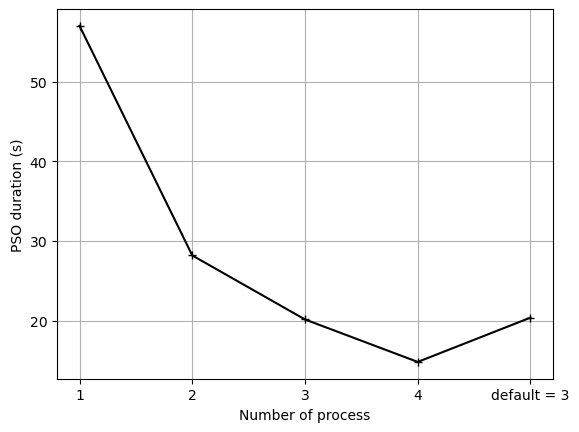

In [2]:
plt.figure()
n_proc_list_int = [1, 2, 3, 4, 5]
n_proc_list_labs = [str(i) for i in n_proc_list_int]
n_proc_list_labs[-1] = f"default = {nrv.parameters.optim_Ncores}"

plt.plot(n_proc_list_int, duration_list, "-+k")
plt.xticks(n_proc_list_int, labels=n_proc_list_labs)
plt.xlabel("Number of process")
plt.ylabel("PSO duration (s)")
plt.grid()